## Capstone Project : Setting up a Bubble Tea Shop in a Singapore Shopping Mall 

The bubble tea craze has hit the second wave in Singapore.  A Taiwanese investor is exploring of entering this market in Singapore and would like to know which districts in Singapore has shopping malls for him to setup a Bubble Tea Shop.  


- Build a dataframe of districts in Singapore by web scraping the data from Wikipedia page
- Get the geographical coordinates of the districtss
- Obtain the venue data for the districts using Foursquare API
- Explore and cluster the districts
- Select the best cluster for the proposed bubble tea shop and recommend which districts within the cluster


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Load Data and Map Districts in Singapore

Scrap data from Wikipedia page into a DataFrame

In [2]:
url = "https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore"
tables = pd.read_html(url, header=0)
print('Number of tables scrapped =',len(tables))

Number of tables scrapped = 4


Subset to required table, drop rows with NaN values, select relevant columns and rename appropriately

In [3]:
# The Planning Areas are in the 3rd table
df = tables[2]  

# remove unwanted columns
df.drop(list(df)[1:5],axis=1,inplace=True)   

# Urban Renewal Authority (URA) refers to the Sub-regions as Planning Areas, Districts will be more familiar to the layman
# rename columns,  use District in place of Planning Area 
df.columns = ['District','Region','Area','Population', 'Density']   

# Remove the districts that population of less than 2000 as they will not be relevant to our analysis.  
# These are probably non-residential areas like Central water catchment areas and off-shore islands.
df=df[df.Population>2000]
df.reset_index(inplace=True,drop=True)

df.head()

,District,Region,Area,Population,Density
0,Ang Mo Kio,North-East,13.94,165710.0,12000.0
1,Bedok,East,21.69,281300.0,13000.0
2,Bishan,Central,7.62,88490.0,12000.0
3,Bukit Batok,West,11.13,144410.0,13000.0
4,Bukit Merah,Central,14.34,151870.0,11000.0


Get the geographical coordinates of each district

In [4]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

Call the function get the latitude and the longitude coordinates of each district to utilise Foursquare location data.

In [5]:
# call the function to get the coordinates, store in a new list 
!pip install geocoder
import geocoder
list_coords = [ get_latlng(neighborhood) for neighborhood in df["District"].tolist() ]
list_coords

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


[[1.3716100000000324, 103.84546000000006],
 [1.324260000000038, 103.95296000000008],
 [1.3507900000000745, 103.85110000000009],
 [1.349520000000041, 103.75277000000006],
 [1.2841700000000742, 103.82306000000005],
 [1.3787700000000314, 103.76977000000005],
 [1.3404100000000199, 103.77221000000009],
 [1.3551400000000626, 103.99006000000008],
 [1.3861600000000749, 103.74618000000004],
 [1.3143800000000283, 103.76537000000008],
 [1.3771599483526997, 103.95552993392594],
 [1.3114700000000425, 103.88218000000006],
 [1.3711400000000253, 103.89144000000005],
 [1.3343700000000354, 103.74367000000007],
 [1.339490000000069, 103.70739000000003],
 [1.3333300000000463, 103.86667000000006],
 [1.412597861239071, 103.7897363168092],
 [1.3030600000000732, 103.90778000000006],
 [1.312180000000069, 103.83912000000004],
 [1.3190700000000675, 103.84374000000008],
 [1.2892320000000015, 103.83499574999999],
 [1.371940000000052, 103.94994000000008],
 [1.402460000000076, 103.90686000000005],
 [1.299660000000074

Merge the new coordinates dataframe and the Singapore districts dataframe 

In [6]:
# correct the long Lat for wrongly geo-coded districts
# Downtown Core
list_coords[10]=[1.286667, 103.853611]
# Singapore River
list_coords[29]=[1.2875, 103.853056]

In [7]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(list_coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

# check the final dataframe and print the size
print(df.shape)
df

(35, 7)


,District,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,165710.0,12000.0,1.371610,103.845460
1,Bedok,East,21.69,281300.0,13000.0,1.324260,103.952960
2,Bishan,Central,7.62,88490.0,12000.0,1.350790,103.851100
3,Bukit Batok,West,11.13,144410.0,13000.0,1.349520,103.752770
4,Bukit Merah,Central,14.34,151870.0,11000.0,1.284170,103.823060
5,Bukit Panjang,West,8.99,140820.0,16000.0,1.378770,103.769770
6,Bukit Timah,Central,17.53,77280.0,4400.0,1.340410,103.772210
7,Changi,East,40.61,2080.0,62.3,1.355140,103.990060
8,Choa Chu Kang,West,6.11,187510.0,31000.0,1.386160,103.746180
9,Clementi,West,9.49,93000.0,9800.0,1.314380,103.765370


Get the long and lat co-ordinates of Singapore

In [8]:
# save the DataFrame as CSV file
df.to_csv("singapore_districts.csv", index=False)

In [9]:
address = 'Singapore, SGP'

# get the coordinates of Singapore
address = 'Singapore'

geolocator = Nominatim(user_agent="Singapore Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore 1.3408528, 103.878446863736.


Create a map of Singapore with its districts superimposed on top.

In [10]:
# create map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district, region in zip(df['Latitude'], df['Longitude'], df['District'], df['Region']):
    label = '{}, {}'.format(district, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

In [11]:
# save the map as HTML file
map_singapore.save('map_singapore.html')

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [12]:
# @hidden_cell
CLIENT_ID = 'VWGXQEYBIEAOSZSHCWX3BQPOB0ZPI2UJPPOSTUKCMIBPTTDP' # your Foursquare ID
CLIENT_SECRET = '5IQTMVQA4HJILXCYUJUGBHUSMSTFKQNHK3DH03XUZQ0G11PQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

## 2. Explore the Venues in the Districts of Singapore

Preview the venues around the district of Downtown CORE (index 13).  This is the Central Business District in Singapore

In [13]:
df.loc[10, 'District']

'Downtown Core'

In [14]:
# Get the district's latitude and longitude values.
neighborhood_latitude = df.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = df.loc[10, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Downtown Core are 1.286667, 103.853611.


In [15]:
# Get the top 100 venues within 500 m radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VWGXQEYBIEAOSZSHCWX3BQPOB0ZPI2UJPPOSTUKCMIBPTTDP&client_secret=5IQTMVQA4HJILXCYUJUGBHUSMSTFKQNHK3DH03XUZQ0G11PQ&v=20180605&ll=1.286667,103.853611&radius=500&limit=100'

In [16]:
# send the GET request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ce4d3dc6a60714939dae4a0'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b05880bf964a520e8ad22e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'primary': True,
         'shortName': 'Hotel'}],
       'id': '4b05880bf964a520e8ad22e3',
       'location': {'address': '1 Fullerton Square',
        'cc': 'SG',
        'city': 'Singapore',
        'country': 'Singapore',
        'crossStreet': 'Financial District',
        'distance': 91,
        'formattedAddress': ['1 Fullerton Square (Financial District)',
         '049178',
         'Singapore'],
        'labeledLatLngs': [{'la

All the information are in the items key.  Now, we will clean the json and structure it into a pandas dataframe.

Define the get_category_type function (from the Foursquare Lab)

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
# All the information are in the items key. Now, we will clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Fullerton Hotel,Hotel,1.286152,103.852972
1,The Merlion,Outdoor Sculpture,1.286717,103.854356
2,One Fullerton,Plaza,1.285797,103.854181
3,Starbucks Reserve Store,Coffee Shop,1.287049,103.853600
4,Cavenagh Bridge,Bridge,1.286596,103.852338


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

72 venues were returned by Foursquare.


In [20]:
nearby_venues

,name,categories,lat,lng
0,The Fullerton Hotel,Hotel,1.286152,103.852972
1,The Merlion,Outdoor Sculpture,1.286717,103.854356
2,One Fullerton,Plaza,1.285797,103.854181
3,Starbucks Reserve Store,Coffee Shop,1.287049,103.853600
4,Cavenagh Bridge,Bridge,1.286596,103.852338
5,Esplanade Park,Park,1.288968,103.853580
6,The Lighthouse Restaurant & Rooftop Bar,Italian Restaurant,1.286231,103.853208
7,Fullerton WaterFront,Waterfront,1.284822,103.853433
8,Asian Civilisations Museum,History Museum,1.287113,103.852052
9,Merlion Park,Sculpture Garden,1.286656,103.854448


Create a function to repeat the same process to all the districts in Singapore

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each district in Singapore and create a new dataframe called singapore_venues.

In [22]:
singapore_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Changi
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Mandai
Marine Parade
Newton
Novena
Outram
Pasir Ris
Punggol
Queenstown
River Valley
Rochor
Sembawang
Sengkang
Serangoon
Singapore River
Tampines
Tanglin
Toa Payoh
Woodlands
Yishun


Check the size of the resulting data frame, singapore_venues

In [23]:
print(singapore_venues.shape)
singapore_venues.head()

(1230, 7)


,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.37161,103.84546,NTUC FairPrice,1.371507,103.847082,Supermarket
1,Ang Mo Kio,1.37161,103.84546,Old Chang Kee,1.369094,103.848389,Snack Place
2,Ang Mo Kio,1.37161,103.84546,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
3,Ang Mo Kio,1.37161,103.84546,Mr Teh Tarik,1.372168,103.845602,Halal Restaurant
4,Ang Mo Kio,1.37161,103.84546,Subway,1.369136,103.847612,Sandwich Place


Check how many venues were returned by each district in Singapore

In [24]:
singapore_venues.groupby('District').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Ang Mo Kio,57,57,57,57,57,57
Bedok,8,8,8,8,8,8
Bishan,45,45,45,45,45,45
Bukit Batok,26,26,26,26,26,26
Bukit Merah,15,15,15,15,15,15
Bukit Panjang,6,6,6,6,6,6
Bukit Timah,56,56,56,56,56,56
Changi,38,38,38,38,38,38
Choa Chu Kang,21,21,21,21,21,21


Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(singapore_venues['Venue Category'].unique())))

There are 193 uniques categories.


In [26]:
# print out the list of categories
singapore_venues['Venue Category'].unique()[:50]

array(['Supermarket', 'Snack Place', 'Noodle House', 'Halal Restaurant',
       'Sandwich Place', 'Asian Restaurant', 'Bank', 'Burger Joint', 'Gym',
       'Bakery', 'Modern European Restaurant', 'Chinese Restaurant',
       'Bubble Tea Shop', 'Fast Food Restaurant', 'Food Court',
       'Hobby Shop', 'Malay Restaurant', 'Japanese Restaurant',
       'Dessert Shop', 'Café', 'Electronics Store', 'Ramen Restaurant',
       'Multiplex', 'Shopping Mall', 'Gym / Fitness Center',
       'Breakfast Spot', 'Vegetarian / Vegan Restaurant',
       'Sushi Restaurant', 'Coffee Shop', 'Pool Hall', 'Pharmacy',
       'Steakhouse', 'Seafood Restaurant', 'Fried Chicken Joint',
       'Cosmetics Shop', 'Thai Restaurant', 'Bus Line', 'Ice Cream Shop',
       'Basketball Court', 'School', 'Trail', 'Resort', 'Pet Store',
       'Portuguese Restaurant', 'Pool', 'Dumpling Restaurant', 'Bookstore',
       'Indian Restaurant', 'Department Store', 'Italian Restaurant'], dtype=object)

## 3. Analyze each District in Singapore

In [27]:
# one hot encoding
singapore_onehot = pd.get_dummies(singapore_venues[['Venue Category']], prefix="", prefix_sep="")

# add District column back to dataframe
singapore_onehot['District'] = singapore_venues['District'] 

# move District column to the first column
fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

singapore_onehot.head()

,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bay,Beer Bar,Beer Garden,Betting Shop,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dumpling Restaurant,Duty-free Shop,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Health Food Store,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Organic Grocery,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Taxi Stand,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wings Joint,Yoga Studio
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [28]:
singapore_onehot.shape

(1230, 194)

Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [29]:
singapore_grouped = singapore_onehot.groupby('District').mean().reset_index()
singapore_grouped

,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bay,Beer Bar,Beer Garden,Betting Shop,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dumpling Restaurant,Duty-free Shop,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Health Food Store,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Organic Grocery,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Taxi Stand,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wings Joint,Yoga Studio
0,Ang Mo Kio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.0000,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.052632,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.0000,0.000000,0.0000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.070175,0.000000,0.000000,0.000000,0.000000,0.087719,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.017544,0.017544,0.000000,0.035088,0.0000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.00000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.

Confirm the new grouped size

In [30]:
singapore_grouped.shape

(35, 194)

Only restrict to 'Bubble Tea Shop' and 'Shopping Mall' venues for this analysis

In [31]:
tea_grouped = singapore_grouped[["District","Bubble Tea Shop","Shopping Mall"]]
tea_grouped.head()

,District,Bubble Tea Shop,Shopping Mall
0,Ang Mo Kio,0.052632,0.017544
1,Bedok,0.000000,0.000000
2,Bishan,0.066667,0.022222
3,Bukit Batok,0.000000,0.038462
4,Bukit Merah,0.000000,0.000000


# 4. Cluster Districts

Run k-means to cluster the districts into 3 clusters.

In [32]:
# set number of clusters
kclusters = 3

tea_grouped_clustering = tea_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tea_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 1, 2, 2, 2, 2, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster.

In [33]:
singapore_merged = tea_grouped.copy()

# add clustering labels
singapore_merged["Cluster Labels"] = kmeans.labels_

# merge singapore_grouped with df to add latitude/longitude and Population data for each district
singapore_merged = singapore_merged.join(df.set_index("District"), on="District")

singapore_merged.head()


,District,Bubble Tea Shop,Shopping Mall,Cluster Labels,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,0.052632,0.017544,0,North-East,13.94,165710.0,12000.0,1.37161,103.84546
1,Bedok,0.000000,0.000000,2,East,21.69,281300.0,13000.0,1.32426,103.95296
2,Bishan,0.066667,0.022222,0,Central,7.62,88490.0,12000.0,1.35079,103.85110
3,Bukit Batok,0.000000,0.038462,1,West,11.13,144410.0,13000.0,1.34952,103.75277
4,Bukit Merah,0.000000,0.000000,2,Central,14.34,151870.0,11000.0,1.28417,103.82306


Finally, let's visualize the resulting clusters

In [34]:
singapore_merged['Cluster Labels']

0     0
1     2
2     0
3     1
4     2
5     2
6     2
7     2
8     0
9     1
10    2
11    2
12    1
13    1
14    2
15    1
16    2
17    1
18    2
19    2
20    2
21    1
22    2
23    2
24    1
25    2
26    1
27    1
28    1
29    2
30    2
31    2
32    2
33    1
34    2
Name: Cluster Labels, dtype: int32

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(singapore_merged['Latitude'], singapore_merged['Longitude'], singapore_merged['District'], singapore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
# save the map as HTML file
map_clusters.save('map_singapore_clusters.html')

## 5. Examine Clusters

Now, we examine each cluster and determine the discriminating characteristics of each cluster. 

### Cluster 1

In [37]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 0]

,District,Bubble Tea Shop,Shopping Mall,Cluster Labels,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,0.052632,0.017544,0,North-East,13.94,165710.0,12000.0,1.37161,103.84546
2,Bishan,0.066667,0.022222,0,Central,7.62,88490.0,12000.0,1.35079,103.85110
8,Choa Chu Kang,0.047619,0.000000,0,West,6.11,187510.0,31000.0,1.38616,103.74618


Cluster 1 shows districts with high penetration rate for bubble tea shops and presence of shopping malls.

### Cluster 2

In [38]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 1]

,District,Bubble Tea Shop,Shopping Mall,Cluster Labels,Region,Area,Population,Density,Latitude,Longitude
3,Bukit Batok,0.000000,0.038462,1,West,11.13,144410.0,13000.0,1.349520,103.752770
9,Clementi,0.000000,0.024390,1,West,9.49,93000.0,9800.0,1.314380,103.765370
12,Hougang,0.000000,0.027778,1,North-East,13.93,223010.0,16000.0,1.371140,103.891440
13,Jurong East,0.028571,0.057143,1,West,17.83,81180.0,4600.0,1.334370,103.743670
15,Kallang,0.000000,0.052632,1,Central,9.17,101420.0,11000.0,1.333330,103.866670
17,Marine Parade,0.000000,0.028571,1,Central,6.12,47250.0,7700.0,1.303060,103.907780
21,Pasir Ris,0.000000,0.029412,1,East,15.02,146920.0,9313.0,1.371940,103.949940
24,River Valley,0.000000,0.048780,1,Central,1.48,9930.0,6230.5,1.295457,103.829902
26,Sembawang,0.000000,0.052632,1,North,12.34,87380.0,6203.3,1.447940,103.818910
27,Sengkang,0.000000,0.034483,1,North-East,10.59,240640.0,19511.0,1.392460,103.894590


Cluster 2 contains districts with presence of shopping malls and almost no (except for Jurong East) presence of bubble tea shops.

### Cluster 3

In [39]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 2]

,District,Bubble Tea Shop,Shopping Mall,Cluster Labels,Region,Area,Population,Density,Latitude,Longitude
1,Bedok,0.000000,0.000000,2,East,21.69,281300.0,13000.0,1.324260,103.952960
4,Bukit Merah,0.000000,0.000000,2,Central,14.34,151870.0,11000.0,1.284170,103.823060
5,Bukit Panjang,0.000000,0.000000,2,West,8.99,140820.0,16000.0,1.378770,103.769770
6,Bukit Timah,0.000000,0.000000,2,Central,17.53,77280.0,4400.0,1.340410,103.772210
7,Changi,0.026316,0.000000,2,East,40.61,2080.0,62.3,1.355140,103.990060
10,Downtown Core,0.000000,0.000000,2,Central,4.34,2510.0,580.0,1.286667,103.853611
11,Geylang,0.000000,0.000000,2,Central,9.64,111610.0,12129.0,1.311470,103.882180
14,Jurong West,0.016667,0.016667,2,West,14.69,266720.0,27000.0,1.339490,103.707390
16,Mandai,0.000000,0.000000,2,North,11.77,2090.0,180.2,1.412598,103.789736
18,Newton,0.000000,0.000000,2,Central,2.07,7640.0,3700.0,1.312180,103.839120


In Cluster 3, the districts has no or low presence of bubble tea shops.  These districts are also characterised by no or few shopping malls. 

### Plot the selected Cluster to analyse possible traffic flow

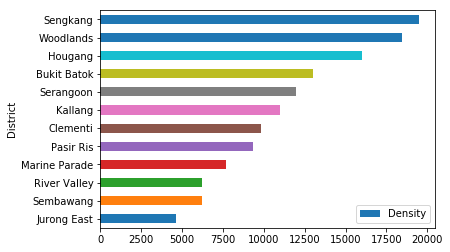

In [40]:
cluster2 = singapore_merged.loc[singapore_merged['Cluster Labels'] == 1].sort_values(by=['Density'])
cluster2.plot(x='District',y='Density',kind='barh')
plt.savefig('PopulationDensity.png')

From the plot, it can be seen that the highest 3 populated districts in Cluster 2 are Sengkang, Woodlands and Hougang.  These will be highly desirable locations to set up a bubble tea shop due to presence of existing shopping malls and a high traffic flow.  These are also away from the Central Business District and rental at the shopping centres will likely be cheaper.

## 6. Conclusion

The clustering results revealed that:
1. Cluster 1 has the highest saturation of bubble tea shops housed within shopping malls.  Intense competition will be expected in these districts.

2. Cluster 2 & 3 has low presence of bubble tea shop in the districts.  The difference in the profiles is that Cluster 2 has the shopping malls whereas Cluster 3 has no or low presence of shopping malls.  The client's prefence is to setup a bubble tea shop in a high-traffic shopping mall so Cluster 3 will not be suitable.

Districts in Cluster 2 will be the most suitable area to setup a bubble tea shop within an existing shopping centre.  To narrow down to the district, we use the population density of the districts to infer the highest traffic flow.  

I would recommend the client to setup a bubble tea shop at either Sengkang, Woodlands or Hougang. 